In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing necessary libraries

In [ ]:
#Importing Libraries
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon

### Reading lightning observation data for Apr and May 2019.

In [ ]:
#Fetching Data
df1=pd.read_csv("/content/drive/MyDrive/Lightning data/LLN_data/2019/apr2019.csv")
df1.head()

,FlashID,PartitionSegmentCode,LightningTimeString,Latitude,Longitude,Height,StrokeType,Amplitude,StrokeSolution,Confidence,FlashDate
0,50189595,8,2019-04-01T23:59:51.368877530,24.69919,93.52262,0,0,-9195,NaN,100,2019-04-01
1,50189596,8,2019-04-02T00:00:22.481124103,25.69389,97.36945,0,0,-12323,NaN,100,2019-04-02
2,50189597,8,2019-04-02T00:00:27.528371691,25.91289,50.17768,0,0,-69060,NaN,100,2019-04-02
3,50189598,8,2019-04-02T00:00:37.870578289,25.21365,97.98381,14111,1,28637,NaN,100,2019-04-02
4,50189599,8,2019-04-02T00:00:56.449927151,6.36559,98.91697,0,0,-81658,NaN,100,2019-04-02


In [ ]:
df2=pd.read_csv("/content/drive/MyDrive/Lightning data/LLN_data/2019/may2019.csv")
df2.head()

,FlashID,PartitionSegmentCode,LightningTimeString,Latitude,Longitude,Height,StrokeType,Amplitude,StrokeSolution,Confidence,FlashDate
0,52200516,9,2019-05-01T23:59:43.132961452,13.05317,83.49233,17736,1,-12657,NaN,100,2019-05-01
1,52200517,9,2019-05-01T23:59:49.719591021,4.29008,73.66397,0,0,-34767,NaN,100,2019-05-01
2,52200518,9,2019-05-02T00:00:38.850230336,13.01763,83.45013,0,0,-12149,NaN,100,2019-05-02
3,52200519,9,2019-05-02T00:00:50.633822977,13.18830,83.86304,16823,1,-7319,NaN,100,2019-05-02
4,52200520,9,2019-05-02T00:01:17.369071424,6.69266,73.64787,0,0,130186,NaN,100,2019-05-02


### Pre-processing

In [ ]:
 frames = [df1, df2]
 df = pd.concat(frames)

In [ ]:
df.drop('FlashID', inplace=True, axis=1)
df.drop('FlashDate', inplace=True, axis=1)
df.drop('PartitionSegmentCode',inplace=True, axis=1)
df.drop('StrokeSolution', inplace=True, axis=1)
df.drop('Confidence', inplace=True, axis=1)
df.drop('StrokeType', inplace=True, axis=1)
df.drop('Height', inplace=True, axis=1)

In [ ]:
li= []

In [ ]:
from dateutil import parser

for i in df.iloc[:,0].to_numpy():
  date_time = i.split('T')[0]+' '+i.split('T')[1].split('.')[0]
  time_obj = parser.parse(date_time)
  li.append(time_obj)
  

In [ ]:
df['date_time'] = li
df.drop('LightningTimeString', inplace=True, axis=1)

In [ ]:
df.head()

,Latitude,Longitude,Amplitude,date_time
0,24.69919,93.52262,-9195,2019-04-01 23:59:51
1,25.69389,97.36945,-12323,2019-04-02 00:00:22
2,25.91289,50.17768,-69060,2019-04-02 00:00:27
3,25.21365,97.98381,28637,2019-04-02 00:00:37
4,6.36559,98.91697,-81658,2019-04-02 00:00:56


In [ ]:
df = df[(df["Latitude"].between(15,22))]

In [ ]:
df = df[(df["Longitude"].between(73,81))]

### Creating 1 hour time intervals

In [ ]:
from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%Y-%m-%dT%H:%M:%S') for dt in 
       datetime_range(datetime(2019, 4, 1, 0), datetime(2019, 6, 1, 0), 
       timedelta(minutes=60))]

time_intervals = []

for i in dts:
  date_time = i.split('T')[0]+' '+i.split('T')[1]
  time_obj = parser.parse(date_time)
  time_intervals.append(time_obj)

print(time_intervals[0])
print(len(time_intervals))

2019-04-01 00:00:00
1464


In [ ]:
lons = np.arange(73,81.25,0.25)

In [ ]:
lats = np.arange(15,22,0.25)

In [ ]:
times = time_intervals  

In [ ]:
data = np.zeros((1464,29,33))

### Storing lightning observation data according to its occurrence over the specific grid.

In [ ]:
for i in range(len(df)):
  date_time = df.iloc[i,3]
  latitude,longitude,amplitude = df.iloc[i,0],df.iloc[i,1],df.iloc[i,2]
  index = 0
  for j in time_intervals:
    if(date_time<=j):
      break
    index+=1
  time_index = index-1
  lat_index,long_index = int(((latitude*10)-150)/2.5), int(((longitude*10)-730)/2.5)
  try:
    if abs(amplitude) > 0:
      data[time_index,lat_index,long_index] = 1
    else:
      data[time_index,lat_index,long_index] = 0
  except:
    print(latitude,longitude)
    break

### Reading the meteorological data.

In [ ]:
import xarray as xr

In [ ]:
ds_disk1 = xr.open_dataset("/content/drive/MyDrive/Lightning data/ERA-5/Single_Level/adaptor.mars.internal-1630659157.581112-27275-9-a1a8991a-4ba4-4391-b12c-83b94e526099.nc")

In [ ]:
ds_disk1

<xarray.Dataset>
Dimensions:    (latitude: 29, longitude: 33, time: 1464)
Coordinates:
  * longitude  (longitude) float32 73.0 73.25 73.5 73.75 ... 80.5 80.75 81.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 15.5 15.25 15.0
  * time       (time) datetime64[ns] 2019-04-01 ... 2019-05-31T23:00:00
Data variables:
    cape       (time, latitude, longitude) float32 ...
    p80.162    (time, latitude, longitude) float32 ...
    p79.162    (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-03 08:52:55 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

In [ ]:
ds_disk1.cape.values.shape

(1464, 29, 33)

In [ ]:
ds_disk2 = xr.open_dataset("/content/drive/MyDrive/Lightning data/ERA-5/Pressure_Levels/2019.nc")

In [ ]:
ds_disk2

<xarray.Dataset>
Dimensions:    (latitude: 29, level: 16, longitude: 33, time: 1464)
Coordinates:
  * longitude  (longitude) float32 73.0 73.25 73.5 73.75 ... 80.5 80.75 81.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 15.5 15.25 15.0
  * level      (level) int32 500 550 600 650 700 750 ... 900 925 950 975 1000
  * time       (time) datetime64[ns] 2019-04-01 ... 2019-05-31T23:00:00
Data variables:
    r          (time, level, latitude, longitude) float32 ...
    clwc       (time, level, latitude, longitude) float32 ...
    t          (time, level, latitude, longitude) float32 ...
    w          (time, level, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-09-03 08:58:36 GMT by grib_to_netcdf-2.20.0: /opt/ecmw...

###  Storing lightning observation data and meteorological data in a xarray dataset.

In [ ]:
times = ds_disk2.time.values
lon = ds_disk2.longitude.values
lat = ds_disk2.latitude.values
pressure = ds_disk2.level.values

In [ ]:
cape = ds_disk1.cape.values
p80_162 = ds_disk1['p80.162'].values
p79_162 = ds_disk1['p79.162'].values

In [ ]:
r = ds_disk2.r.values
clwc = ds_disk2.clwc.values
t = ds_disk2.t.values
w = ds_disk2.w.values

In [ ]:
data_2019 = xr.Dataset(
    {
        "r":(          
          ("time", "level", "latitude", "longitude"),
          r,
          dict(
            units = '%',
            long_name= 'Relative humidity',
            standard_name= 'relative_humidity',
            ),
        ),
        "clwc":(
          ("time", "level", "latitude", "longitude"),
          clwc,
          dict(
            units = 'kg kg**-1',
            long_name= 'Specific cloud liquid water content',
            ),
        ),
        "t":(
          ("time", "level", "latitude", "longitude"),
          t,
          dict(
            units = 'K',
            long_name= 'Temperature',
            standard_name = 'air_temperature',
            ),  
        ),
        "w":(
          ("time", "level", "latitude", "longitude"),
          w,  
          dict(
            units = 'Pa s**-1',
            long_name= 'Vertical velocity',
            standard_name = 'lagrangian_tendency_of_air_pressure',
            ), 
        ),
        "cape":(
            ("time", "latitude", "longitude"),
            cape,
            dict(
            units = 'J kg**-1',
            long_name= 'Convective available potential energy',
            ),
        ),
       "p80.162":(
           ("time", "latitude", "longitude"),
           p80_162,
           dict(
            units = 'kg m**-2 s**-1',
            long_name= 'Vertical integral of divergence of cloud frozen water flux',
            ),
       ),
       "p79.162":(
           ("time", "latitude", "longitude"),
           p79_162,
           dict(
            units = 'kg m**-2 s**-1',
            long_name= 'Vertical integral of divergence of cloud liquid water flux',
            ),
       ),
      "Amplitude":(
           ("time", "latitude", "longitude"),
           data,
           dict(
            units = 'Amp',
            long_name= 'Amplitude of lightning',
            ),
       ),
    },
    coords={"longitude": lon, "latitude": lat, "level": pressure ,"time": times},
    attrs=dict(description="Parameters affecting lightning data."),
)

In [ ]:
data_2019

<xarray.Dataset>
Dimensions:    (latitude: 29, level: 16, longitude: 33, time: 1464)
Coordinates:
  * longitude  (longitude) float32 73.0 73.25 73.5 73.75 ... 80.5 80.75 81.0
  * latitude   (latitude) float32 22.0 21.75 21.5 21.25 ... 15.5 15.25 15.0
  * level      (level) int32 500 550 600 650 700 750 ... 900 925 950 975 1000
  * time       (time) datetime64[ns] 2019-04-01 ... 2019-05-31T23:00:00
Data variables:
    r          (time, level, latitude, longitude) float32 6.455 5.76 ... 86.08
    clwc       (time, level, latitude, longitude) float32 0.0 0.0 ... 0.0 0.0
    t          (time, level, latitude, longitude) float32 265.2 265.2 ... 302.6
    w          (time, level, latitude, longitude) float32 -0.02386 ... -0.01137
    cape       (time, latitude, longitude) float32 60.3 105.4 ... 4.92e+03
    p80.162    (time, latitude, longitude) float32 8.812e-08 ... -3.172e-07
    p79.162    (time, latitude, longitude) float32 1.196e-06 ... 2.148e-06
    Amplitude  (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    description:  Parameters affecting lightning data.

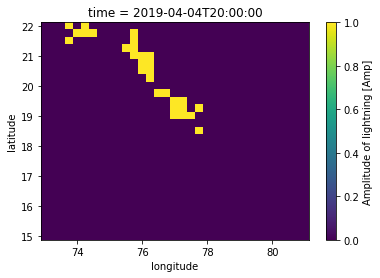

In [ ]:
plot2d = data_2019.Amplitude.isel(time=92)
plot2d.plot()

### Storing the data as netcdf file.

In [ ]:
data_2019.to_netcdf('/content/drive/MyDrive/Lightning data/S13/data2019.nc')